In [2]:
!pip install pytesseract
!pip install imutils
!pip install opencv-python

In [3]:
from imutils.object_detection import non_max_suppression
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import imutils
import numpy as np
import requests
import pytesseract
import cv2

In [4]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

def decode_predictions(scores, geometry):
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	for y in range(0, numRows):
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		for x in range(0, numCols):
			if scoresData[x] < min_confidence:
				continue

			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	return (rects, confidences)

In [9]:
layerNames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

# 사전에 훈련된 EAST text detector 모델 Load
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("model/frozen_east_text_detection.pb")

[INFO] loading EAST text detector...


In [10]:
width = 640
height = 640
min_confidence = 0.5
padding = 0.0

Saving IMG_OCR_53_4PR_29588.png to IMG_OCR_53_4PR_29588.png


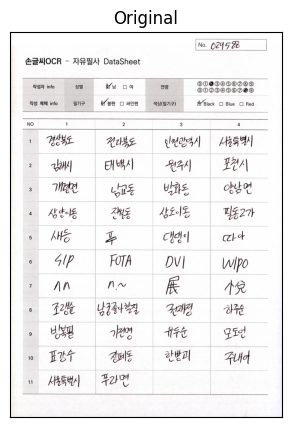

In [23]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일에서 이미지 읽기 (파일 이름은 업로드 시 결정됨)
filename = next(iter(uploaded))
image_nparray = np.asarray(bytearray(uploaded[filename]), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

plt_imshow("Original", org_image)

In [24]:
orig = org_image.copy()
(origH, origW) = org_image.shape[:2]

(newW, newH) = (width, height)
rW = origW / float(newW)
rH = origH / float(newH)

org_image = cv2.resize(org_image, (newW, newH))
(H, W) = org_image.shape[:2]

In [25]:
blob = cv2.dnn.blobFromImage(org_image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [26]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [27]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Replace with the actual path if different

In [28]:
results = []

for (startX, startY, endX, endY) in boxes:
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	dX = int((endX - startX) * padding)
	dY = int((endY - startY) * padding)

	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))

	# 영역 추출
	roi = orig[startY:endY, startX:endX]

	config = ("-l eng --psm 4")
	text = pytesseract.image_to_string(roi, config=config)

	results.append(((startX, startY, endX, endY), text))

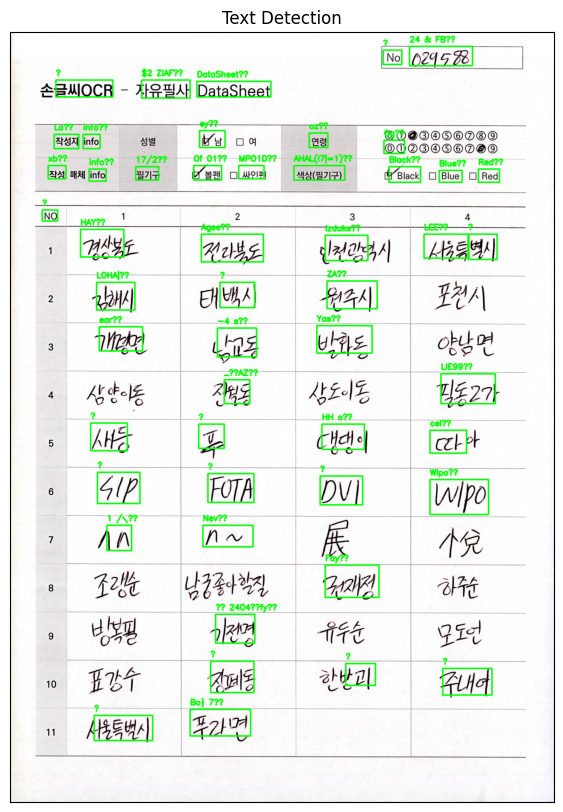

In [29]:
results = sorted(results, key=lambda r:r[0][1])

output = orig.copy()

# 결과 출력
for ((startX, startY, endX, endY), text) in results:
	cv2.rectangle(output, (startX, startY), (endX, endY), (0, 255, 0), 5)
	cv2.putText(output, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 5)


plt_imshow("Text Detection", output, figsize=(16, 10))